In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random
from sklearn.decomposition import PCA
from matplotlib.colors import to_rgba
from sklearn.preprocessing import StandardScaler
import re
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

from utils import *

random.seed(a=1)

condition_labels = ['Cross PFA', 'Cross FA', 'Cross Local', 'Intra PFA', 'Intra FA', 'Intra Local']

In [ ]:
title_fontsize = 18
labels_fontsize = 18
ticks_fontsize = 18

# Customizing fonts globally to use Arial (or another sans-serif font)
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': labels_fontsize,
    'axes.titlesize': title_fontsize,
    'axes.labelsize': labels_fontsize,
    'legend.fontsize': 18, 
})

def get_color_and_alpha(idx, total, base_color, min_alpha=0.2, max_alpha=1.0, min_frac = 0.3, max_frac=0.0):
    alpha = min_alpha + (max_alpha - min_alpha) * (idx / max(total-1, 1))
    frac = min_frac * (1 - idx / max(total-1, 1)) + max_frac * (idx / max(total-1, 1))
    from matplotlib.colors import to_rgba
    base_rgba = np.array(to_rgba(base_color))
    white = np.array([1, 1, 1, 1])
    color = white * frac + base_rgba * (1 - frac)
    color[-1] = alpha
    return color


## Load In Data

In [ ]:
# OPEN LOOP DECODERS
## This data is not public

base_path = "C:\\Users\\kdmen\\Repos\\personalization-privacy-risk\\Main_PythonVersion\\Main_Final\\results\\IEEE_Final"

# CROSS
cpfa_model_dict = load_model_logs(base_path+r'\\Cross_PFAFO', 'GD_PFAFO_KFold')
cfa_model_dict = load_model_logs(base_path+r'\\Cross_FEDAVG', 'GD_FEDAVG_KFold')
cnofl_model_dict = load_model_logs(base_path+r'\\Cross_NOFL', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
ipfa_model_dict = load_model_logs(base_path+r'\\Intra_PFAFO', 'GD_PFAFO_KFold')
ifa_model_dict = load_model_logs(base_path+r'\\Intra_FEDAVG', 'GD_FEDAVG_KFold')
inofl_model_dict = load_model_logs(base_path+r'\\Intra_NOFL', 'FULLSCIPYMIN_NOFL_KFold')


In [4]:
# LOAD CLOSED LOOP DATA

CL_subjs_lst = ["S101", "S102", "S103", "S104", "S105", "S106", "S108", "S109", "S110", "S111", "S112", "S113", "S114", "S115", "S116", "S117"]

closed_loop_subj_dicts = {}
for SUBJECT_STR in CL_subjs_lst:
    BASEPATH_BRC = r'C:\\Users\\kdmen\\Box\\Yamagami Lab\\Data\\2024_IMWUT_EMG_FL\\User Study\\User Study - Pickle Files\\' 
    basepath = BASEPATH_BRC + SUBJECT_STR 
    save_file = basepath + "_unique_decoders_lri_lsi_pri_psi.pkl"
    with open(save_file, 'rb') as f:
        closed_loop_subj_dicts[SUBJECT_STR] = pickle.load(f)
    

In [5]:
closed_loop_subj_dicts.keys()

dict_keys(['S101', 'S102', 'S103', 'S104', 'S105', 'S106', 'S108', 'S109', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117'])

In [6]:
# CLOSED LOOP

subjects = list(closed_loop_subj_dicts.keys())
conditions = ["lri", "lsi", "pri", "psi"]

# ===== 1. Flatten all decoders and store meta info =====
decoder_rows = []
meta_info = []  # stores (subject, condition, decoder_idx, total_decoders)

for subj in subjects:
    for cond in conditions:
        decoders = closed_loop_subj_dicts[subj][cond]
        num_decoders = len(decoders)
        for idx, dec in enumerate(decoders):
            decoder_rows.append(np.array(dec).flatten())
            meta_info.append((subj, cond, idx, num_decoders))

decoder_matrix = np.stack(decoder_rows)  # shape: (N_total_decoders, D)

# ===== 2. Run PCA to reduce to 2D =====

# Standardize the weights (mean 0, std 1)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(decoder_matrix)
X_ms = decoder_matrix - np.mean(decoder_matrix, axis=0)

pca = PCA(n_components=2)
decoder_2d = pca.fit_transform(X_ms)

# ===== 3. Build a lookup DataFrame =====
CL_PCA_noMS_df = pd.DataFrame(meta_info, columns=["subject", "condition", "decoder_idx", "total_decoders"])
CL_PCA_noMS_df["PC1"] = decoder_2d[:, 0]
CL_PCA_noMS_df["PC2"] = decoder_2d[:, 1]

subj_colors = {subj: plt.cm.tab20(i % 20) for i, subj in enumerate(subjects)}


In [ ]:
# ========== SETUP ==========

OL_dicts = {
    'perfedavg_cross': cpfa_model_dict,
    'fedavg_cross': cfa_model_dict,
    'nofl_cross': cnofl_model_dict,
    'perfedavg_intra': ipfa_model_dict,
    'fedavg_intra': ifa_model_dict,
    'nofl_intra': inofl_model_dict
}
fold_number = "1"

# ---------- Helper Function: Extract Subject & Fold ----------
def parse_key(key):
    """Extracts subject ID and fold number from key string."""
    m = re.match(r'(S\d+).*fold(\d+)', key)
    if m:
        return m.group(1), m.group(2)
    return None, None

# ========== 1. Collect All Decoders + Meta-Info ==========
decoder_rows = []
meta_info = []

for cond_name, model_dict in OL_dicts.items():
    algo, scenario = cond_name.split('_')
    # --- Subject decoders ---
    for key, model_list in model_dict.items():
        if key.startswith('global'):
            continue
        subj_id, fold = parse_key(key)
        if fold != fold_number or subj_id is None:
            continue
        num_decoders = len(model_list)
        for idx, dec in enumerate(model_list):
            flat_dec = np.array(dec).flatten()
            decoder_rows.append(flat_dec)
            meta_info.append((
                subj_id, cond_name, algo, scenario, fold, idx, num_decoders, False  # is_global=False
            ))
    # --- Global models (fedavg, perfedavg only) ---
    if algo in ['fedavg', 'perfedavg']:
        global_key = f'global_dec_log_fold{fold_number}'
        if global_key in model_dict:
            global_models = model_dict[global_key]
            num_decoders = len(global_models)
            for idx, dec in enumerate(global_models):
                flat_dec = np.array(dec).flatten()
                decoder_rows.append(flat_dec)
                meta_info.append((
                    'GLOBAL', cond_name, algo, scenario, fold_number, idx, num_decoders, True  # is_global=True
                ))

# ----- Build DataFrame with All Decoders -----
decoder_matrix = np.stack(decoder_rows)
meta_cols = ["subject", "condition", "algorithm", "scenario", "fold", "decoder_idx", "total_decoders", "is_global"]
OL_pca_df = pd.DataFrame(meta_info, columns=meta_cols)

# ========== 2. "Distance to Final" Analysis ==========
# (per subject/condition, distance to that subject's final decoder for fold 1)
final_dist_records = []
group_cols = ["subject", "condition", "is_global"]
for _, group in OL_pca_df.groupby(group_cols):
    # Only analyze groups with more than 1 decoder
    if group.shape[0] < 2:
        continue
    group = group.sort_values("decoder_idx")
    final_vec = decoder_matrix[group.index[-1]]
    for i, idx in enumerate(group.index[:-1]):
        curr_vec = decoder_matrix[idx]
        dist = np.linalg.norm(curr_vec - final_vec)
        rec = {k: group.iloc[i][k] for k in meta_cols}
        rec['model_index'] = group.iloc[i]['decoder_idx']
        rec['distance_to_final'] = dist
        final_dist_records.append(rec)

final_dist_df = pd.DataFrame(final_dist_records)

# ========== 3. PCA Embedding ==========
# NO SCALING: Preserve the differences between algorithms
#scaler = StandardScaler()
#X_ppd = scaler.fit_transform(decoder_matrix)
X_ppd = decoder_matrix - np.mean(decoder_matrix, axis=0)

pca = PCA(n_components=2)
decoder_2d = pca.fit_transform(X_ppd)
OL_pca_df["PC1"] = decoder_2d[:, 0]
OL_pca_df["PC2"] = decoder_2d[:, 1]

# ========== 4. Prepare for Plotting ==========
OL_subjects = sorted([s for s in OL_pca_df["subject"].unique() if s != "GLOBAL"])
OL_conditions = sorted(OL_pca_df["condition"].unique())
OL_algorithms = sorted(OL_pca_df["algorithm"].unique())


decoder_matrix.shape: (12348, 128)
X_ppd.shape: (12348, 128)


In [8]:
print(final_dist_df.shape)
final_dist_df.head()

(12260, 10)


,subject,condition,algorithm,scenario,fold,decoder_idx,total_decoders,is_global,model_index,distance_to_final
0,GLOBAL,fedavg_cross,fedavg,cross,1,0,501,True,0,5.682644
1,GLOBAL,fedavg_cross,fedavg,cross,1,1,501,True,1,5.228557
2,GLOBAL,fedavg_cross,fedavg,cross,1,2,501,True,2,4.496024
3,GLOBAL,fedavg_cross,fedavg,cross,1,3,501,True,3,3.895607
4,GLOBAL,fedavg_cross,fedavg,cross,1,4,501,True,4,3.627576


In [9]:
print(OL_pca_df.shape)
OL_pca_df.head()

(12348, 10)


,subject,condition,algorithm,scenario,fold,decoder_idx,total_decoders,is_global,PC1,PC2
0,S0,perfedavg_cross,perfedavg,cross,1,0,1,False,-4.031559,0.256756
1,S10,perfedavg_cross,perfedavg,cross,1,0,202,False,-4.031559,0.256756
2,S10,perfedavg_cross,perfedavg,cross,1,1,202,False,-3.978519,0.253232
3,S10,perfedavg_cross,perfedavg,cross,1,2,202,False,-3.084286,0.282924
4,S10,perfedavg_cross,perfedavg,cross,1,3,202,False,-2.855332,0.283972


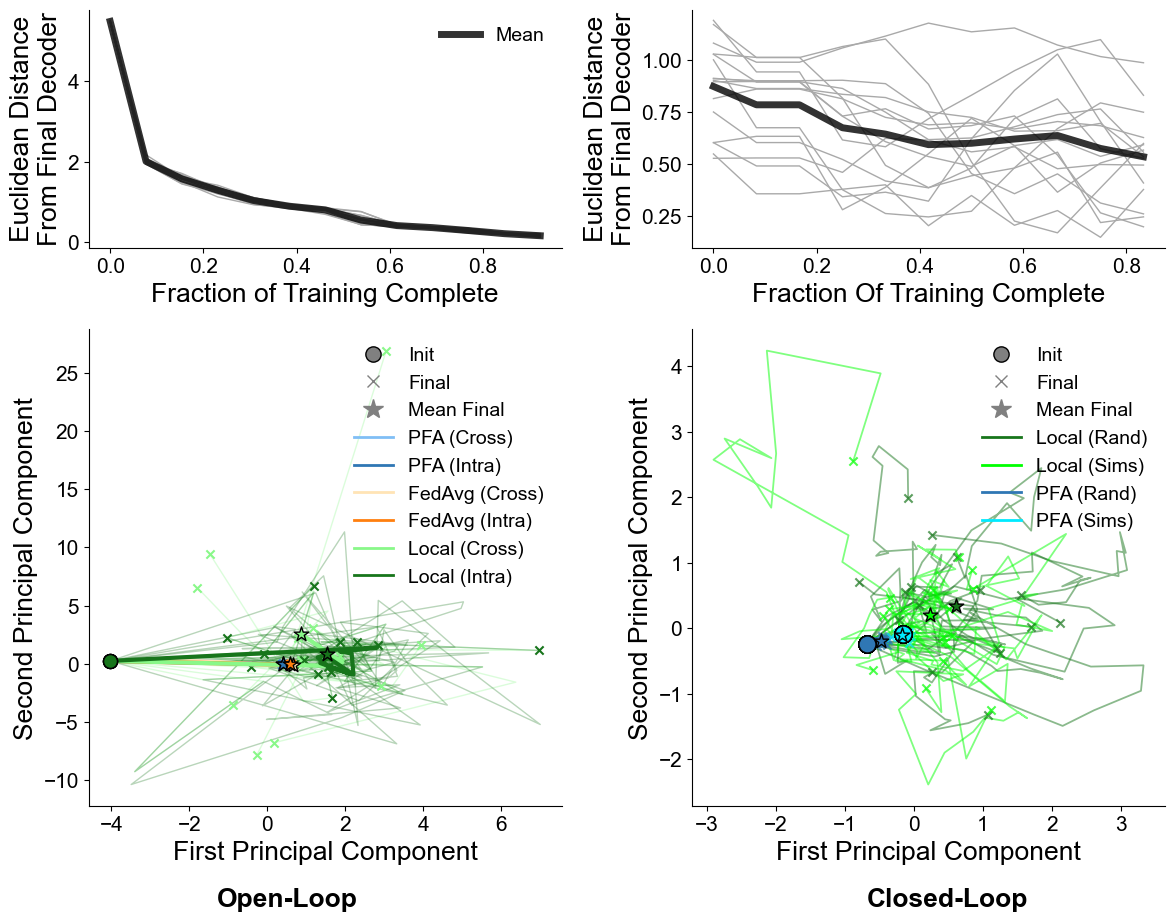

In [ ]:
OL_subjects = final_dist_df['subject'].unique()
CL_subjects = closed_loop_subj_dicts.keys()
OL_conditions = ['perfedavg_cross', 'perfedavg_intra', 'fedavg_cross', 'fedavg_intra', 'nofl_cross', 'nofl_intra']
CL_conditions = ["lri", "lsi", "pri", "psi"]

OL_conds_map = {
    'nofl_cross': "Local (Cross)",
    'fedavg_cross': "FedAvg (Cross)",
    'perfedavg_cross': "PFA (Cross)",
    'nofl_intra': "Local (Intra)",
    'fedavg_intra': "FedAvg (Intra)",
    'perfedavg_intra': "PFA (Intra)"
}

CL_conds_map = {
    'lri': "Local (Rand)",
    'lsi': "Local (Sims)",
    'pri': "PFA (Rand)",
    'psi': "PFA (Sims)"
}

legend_fontsize = 14
default_fontsize = 15
title_fontsize = 19
label_fontsize = 19
tick_fontisze = 15
plt.rcParams.update({'font.size': default_fontsize, 'axes.titlesize': title_fontsize, 
                     'axes.labelsize': label_fontsize, 'xtick.labelsize': tick_fontisze, 
                     'ytick.labelsize': tick_fontisze, 'legend.fontsize': legend_fontsize})

cond_colors = {
    "perfedavg_cross": "#80BEF5",
    "perfedavg_intra": "#2f77b4", ###

    "fedavg_cross": "#ffe4b5",
    "fedavg_intra": "#ff7f0e",

    "nofl_cross": "#89f889",
    "nofl_intra": "#17751b" ###
}

cond_abrv_colors = {
    "lri": "#17751b", ###
    "lsi": "#00ff00", 
    "pri": "#2f77b4", ###
    "psi": "#00EAFFFF"
}

top_plot_base_color = 'darkgrey'
top_plot_mean_color = 'black'

fig = plt.figure(figsize=(12, 9))
# Define grid layout with different row heights
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])  # First row is shorter, second row is taller
# Create subplots
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

# --- AX 0: Open-Loop Intra Per-FedAvg (with sampling) ---
ax = axes[0]
cond = "perfedavg_intra"

num_samples = 14
x0 = np.linspace(0, 1, num_samples)   # fraction‐trained axis
all_dists = []

for subj in OL_subjects:
    subj_df = final_dist_df[
        (final_dist_df['subject'] == subj) &
        (final_dist_df['condition'] == cond)
    ]
    if subj_df.empty or subj == "GLOBAL":
        continue

    # original distances (variable length)
    d = subj_df['distance_to_final'].values
    # sample 14 evenly‐spaced points via interpolation
    sampled = np.interp(
        np.linspace(0, len(d) - 1, num_samples),
        np.arange(len(d)),
        d
    )
    all_dists.append(sampled)

    # plot each subject in gray
    ax.plot(x0[:-1], sampled[:-1], alpha=1, linewidth=1, color=top_plot_base_color)

# compute & plot mean curve
if all_dists:
    mean_dist = np.mean(np.vstack(all_dists), axis=0)
    ax.plot(x0[:-1], mean_dist[:-1], linewidth=5, color=top_plot_mean_color,
            label='Mean', alpha=0.8)

ax.set_xlabel("Fraction of Training Complete")
ax.set_ylabel("Euclidean Distance\nFrom Final Decoder")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=legend_fontsize,
          title_fontsize=legend_fontsize+2,
          frameon=False,
          loc='upper right')


# --- AX 1: Closed-Loop Per-FedAvg, colored by subject ---
ax = axes[1]
n = len(closed_loop_subj_dicts["S108"]['pri'])
frac_train = np.linspace(0, 1, n)[:11]

all_norms = []
for subj in CL_subjects:
    pri = closed_loop_subj_dicts[subj]['pri']
    final_dec = pri[-1]

    # L2 norm from final, first 11 points
    delta = np.array(pri) - final_dec
    norms = np.linalg.norm(delta, ord=2, axis=(1,2))[:11]
    all_norms.append(norms)

    # plot each in gray
    ax.plot(frac_train, norms,
            alpha=1, linewidth=1, color=top_plot_base_color)

# compute & plot mean
if all_norms:
    mean_norm = np.mean(np.stack(all_norms, axis=0), axis=0)
    ax.plot(frac_train, mean_norm, linewidth=5, color=top_plot_mean_color, alpha=0.8)
    #ax.legend(frameon=False, fontsize=legend_fontsize)

ax.set_xlabel("Fraction Of Training Complete")
ax.set_ylabel("Euclidean Distance\nFrom Final Decoder")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# --- AX 2: Open-Loop PCA Trajectories with per-condition mean overlay & down-sampling ---
ax = axes[2]
legend_handles = []

for cond_idx, cond in enumerate(OL_conditions):
    color = cond_colors[cond]
    subj_trajs = []

    # 1) collect each subject's raw trajectory
    for subj in OL_subjects:
        cond_df = OL_pca_df[
            (OL_pca_df["subject"]   == subj) &
            (OL_pca_df["condition"] == cond)
        ]
        if cond_df.empty:
            continue

        X = cond_df["PC1"].values
        Y = cond_df["PC2"].values
        traj = np.stack((X, Y), axis=1)  # shape (T,2)

        # skip degenerate runs
        if traj.shape[0] <= 1:
            continue

        subj_trajs.append(traj)

        # plot raw
        ax.plot(X, Y, color=color, alpha=0.3, linewidth=1)
        ax.scatter(X[0],  Y[0],  color=color, edgecolor='k',
                   s=35, marker='o', zorder=15)
        ax.scatter(X[-1], Y[-1], color=color,
                   s=35, marker='x', zorder=12)

    if not subj_trajs:
        continue

    # 2) down-sample all to the same length Lmin
    lengths = [t.shape[0] for t in subj_trajs]
    Lmin = min(lengths)
    resampled = []
    for t in subj_trajs:
        T = t.shape[0]
        # compute Lmin indices equally spaced over [0, T-1]
        idxs = np.linspace(0, T-1, num=Lmin)
        idxs = np.round(idxs).astype(int)
        resampled.append(t[idxs, :])
    subj_trajs = resampled

    # 3) compute mean trajectory
    arr = np.stack(subj_trajs, axis=0)       # (n_subj, Lmin, 2)
    Xavg = arr[:,:,0].mean(axis=0)           # (Lmin,)
    Yavg = arr[:,:,1].mean(axis=0)

    # 4) overplot mean
    h, = ax.plot(Xavg, Yavg,
                 color=color, linewidth=3, alpha=1.0,
                 zorder=20)
    ax.scatter(Xavg[0],  Yavg[0],
               color=color, edgecolor='k',
               s=100, marker='o', zorder=21)
    ax.scatter(Xavg[-1], Yavg[-1],
               color=color, edgecolor='k',
               s=120, marker='*', zorder=21)

    legend_handles.append(h)

# 5) finalize legend & labels
#legend_labels = [condition_labels[i] for i in range(len(legend_handles))]
#ax.legend(legend_handles, legend_labels, fontsize=legend_fontsize, frameon=False)
line_handles = [Line2D([0], [0], color=cond_colors[c], lw=2, label=OL_conds_map[c]) for c in OL_conditions]
# Generic handles for markers
circle_handle = Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='k',
                       markersize=11, label='Init', lw=0)
x_handle      = Line2D([0], [0], marker='x', color='gray', markersize=9, label='Final', lw=0)
star_handle   = Line2D([0], [0], marker='*', color='gray', markersize=15, label='Mean Final', lw=0)
# Combine all handles
handles =  [circle_handle, x_handle, star_handle] + line_handles
labels = ['Init', 'Final', 'Mean Final'] + [OL_conds_map[c] for c in OL_conditions]
# Put legend in best position (or use bbox_to_anchor, loc as needed)
ax.legend(handles, labels, loc='best', frameon=False, fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)  #, title='Legend'

ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.text(5.5, -0.5, 'Init\nModel', fontsize=legend_fontsize, ha='center', va='center')
#ax.text(-1.5, -0.5, 'Final\nModel', fontsize=legend_fontsize, ha='center', va='center')


# --- AX 3: Closed-Loop PCA Trajectories, colored by condition, show all start circles and average star ---
ax = axes[3]
for cond_idx, cond in enumerate(CL_conditions):
    color = cond_abrv_colors[cond]
    ends = []
    starts = []
    subj_sizes = 150 #np.linspace(85, 30, num=len(CL_subjects))  # Different sizes for circles, largest first
    for j, subj in enumerate(CL_subjects):
        cond_df = CL_PCA_noMS_df[(CL_PCA_noMS_df["subject"] == subj) & (CL_PCA_noMS_df["condition"] == cond)]
        if cond_df.empty: continue
        X, Y = cond_df["PC1"].values, cond_df["PC2"].values
        ax.plot(X, Y, color=color, alpha=0.5, linewidth=1.3, zorder=1)
        # Store starts and ends for plotting after all lines (to layer properly)
        starts.append((X[0], Y[0], subj_sizes))  #[j]
        ends.append([X[-1], Y[-1]])
        ax.scatter(X[-1], Y[-1], color=color, s=35, marker='x', zorder=12, alpha=0.7)  # End
    # Plot all starts after all lines, largest first
    starts = sorted(starts, key=lambda x: -x[2])
    for x, y, s in starts:
        ax.scatter(x, y, color=color, edgecolor='k', s=s, marker='o', zorder=18, alpha=1.0)
    # Mean of end points
    ends = np.array(ends)
    if len(ends) > 0:
        mean_pt = ends.mean(axis=0)
        ax.scatter(mean_pt[0], mean_pt[1], color=color, edgecolor='k', s=120, marker='*', zorder=20, alpha=1.0)

# Legend for colored lines (condition)
line_handles = [Line2D([0], [0], color=cond_abrv_colors[c], lw=2, label=CL_conds_map[c]) for c in CL_conditions]
# Generic handles for markers
circle_handle = Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='k',
                       markersize=11, label='Init', lw=0)
x_handle      = Line2D([0], [0], marker='x', color='gray', markersize=9, label='Final', lw=0)
star_handle   = Line2D([0], [0], marker='*', color='gray', markersize=15, label='Mean Final', lw=0)
# Combine all handles
handles =  [circle_handle, x_handle, star_handle] + line_handles
labels = ['Init', 'Final', 'Mean Final'] + [CL_conds_map[c] for c in CL_conditions]
# Put legend in best position (or use bbox_to_anchor, loc as needed)
ax.legend(handles, labels, loc='best', frameon=False, fontsize=legend_fontsize, title_fontsize=legend_fontsize+2)  #, title='Legend'

#ax.set_title("Closed-Loop Subject Decoder PCA Trajectories")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 1])

# Add bold labels under each column
fig.text(
    0.25, -0.00, r'Open-Loop',
    ha='center', va='top', fontsize=label_fontsize, fontweight='bold'
)
fig.text(
    0.8, -0.00, r'Closed-Loop',
    ha='center', va='top', fontsize=label_fontsize, fontweight='bold'
)

plt.savefig('DecAn_Appendix.png', dpi=500, bbox_inches='tight')
plt.show()
